In [1]:
from fastai import * 
from fastai.data.all import *
from fastai.vision.data import * 
from fastai.vision.core import *
from fastai.vision.all import *
from torchvision import transforms
from torch_lr_finder import LRFinder
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data as data
from torch import nn, optim
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
import re
import os
import glob
from skimage import io, color, img_as_float32, img_as_uint
import random
import numpy as np
import PIL
import glob
import gc
from torch.optim.lr_scheduler import _LRScheduler
from sklearn.metrics import fbeta_score
import sys
import builtins
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix
import pickle
import pandas
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold

/home/fs541623/.conda/envs/fastai/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
print('----------------------running script---------------')
fnames = get_image_files('/hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Cropped_Cells')
path_glob = glob.glob('/hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Cropped_Cells/*/*/*/*')
path_img = '/hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Cropped_Cells'

----------------------running script---------------


In [ ]:
len(fnames)

In [3]:
def label_func(fname):
    return (re.match(r'.*(Time_\d+hrs).*(Well_\d+).*', fname.name).groups())
labels = np.unique(list(zip(*(set(fnames.map(label_func))))))
label_n = len(np.unique(labels))
classes=len(labels)
labels_encoder = {metadata:l for l, metadata in enumerate(labels)}

In [4]:
def label_encoder(fname):
    time, well = re.match(r'.*(Time_\d+hrs).*(Well_\d+).*', fname.name).groups()
    return labels_encoder[time], labels_encoder[well]
indxs = np.random.permutation(range(int(len(fnames))))
dset_cut = int(len(fnames)*0.8)

In [5]:
## Split into train & val
train_files = fnames[indxs[:dset_cut]]
valid_files = fnames[indxs[dset_cut:]]

In [6]:
## Get labels for shuffled files
train_y = train_files.map(label_encoder)
valid_y = valid_files.map(label_encoder)

In [ ]:
## Dataset 
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.transform = transforms.Resize(224)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img = img_as_float32(Image.open(self.x[idx]))
        out = np.zeros((1,14), int) # TO DO : refactor 
        out[[0,0], np.array(self.y[idx])] = 1
        return (self.transform(torch.tensor((img[None]))), torch.tensor(out, dtype=float).squeeze())

In [ ]:
## Create Datasets 
train_ds = Dataset(train_files, train_y) 
valid_ds = Dataset(valid_files, valid_y)

In [5]:
def label_decoder(labels):
    label_array=np.array(list(labels_encoder))
    idx = np.array(labels).astype(int) > 0 
    return label_array[idx]

In [ ]:
#dataloaders
valid_iterator = data.DataLoader(valid_ds, batch_size=1,shuffle=False, pin_memory=True)

In [ ]:
print('---------------Getting model-----------')
# model 
def conv_layer(inputs, outputs, ks, stride, padding, use_activation=None):
    layers=[nn.Conv2d(inputs, outputs, ks, stride, padding, bias=False), nn.BatchNorm2d(outputs)]
    if use_activation: layers.append(nn.ReLU(inplace=True))
    return nn.Sequential(*layers)

# Residual Block 
class residual(nn.Module):
    def __init__(self, input_channels, out_channels, stride=1, activation: torch.nn.Module = nn.ReLU(inplace=True)):
        super().__init__()
    
        # 64 -> 256 ; always first block in resnetlayer
        self.convs = nn.Sequential(*[conv_layer(input_channels, out_channels, 1, 1, 0, use_activation=True),
                                     conv_layer(out_channels, out_channels, 3, stride, 1, use_activation=True),
                                     conv_layer(out_channels, out_channels*4, 1, 1, 0, use_activation=True)])
        
        # if 256 == 4*64 (256) e.g. for other blocks of resnet layer 
        if input_channels == out_channels*4: 
            self.conv4 = nn.Identity()
            print(f'identity layer:{input_channels, out_channels, out_channels*4}')
        else: 
            # if 64 != 256 ( 4*64) -> do convolutional layer
            print(f'residual conv layer:{input_channels, out_channels, out_channels*4}')
            self.conv4 = conv_layer(input_channels, out_channels*4, 1, stride, 0)
        
        self.activation = activation
        
    def forward(self, X):
        return self.activation((self.convs(X) + self.conv4(X)))

## Need to refactor 
class resnetmodel(nn.Module):
    def __init__(self, channels, n_blocks, classes=classes):
        super().__init__()
        self.in_channels = channels[0] # 64
        
        ## to work with 1 channel images
        self.model_stem = nn.Sequential(*[conv_layer(1, self.in_channels, ks=7, stride=2, padding=3, use_activation=True), 
                                     nn.MaxPool2d(3, stride=2, padding=1)])
        self.res_layer1 = self._make_res(residual, channels[0], n_blocks[0])
        self.res_layer2 = self._make_res(residual, channels[1], n_blocks[1], stride=2)
        self.res_layer3 = self._make_res(residual,channels[2], n_blocks[2], stride=2)
        self.res_layer4 = self._make_res(residual, channels[3], n_blocks[3], stride=2)
        
        # inchannels = 2048??
        self.adpool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(self.in_channels, classes)
        
    
    def _make_res(self, residual, channels, n_blocks, stride=1):
        # 1st reslayer doesnt have stride == 2 
        layers = []
        
        # 1st block of each res layer always has stride == 1
        # e.g. inchannels = 64, channels = 64 --> ends up outputting channels 4*64 = 256
        
        print(f'input channels to next layer: {channels}')
        
        # convolution block
        layers.append(residual(self.in_channels, channels)) # 256 -> 128 (128 * 4 = 512)
        
        # identity blocks
        for i in range(1, n_blocks):
            # input channels = 256 -> 64 
            layers.append(residual(channels*4, channels)) # 128*4 = 512 -> 512 (128 * 4)
        self.in_channels = 4*channels # set in_channels for next convolution block
        print(f'outchannels: {self.in_channels}')
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.model_stem(x)
        x = self.res_layer1(x) 
        x = self.res_layer2(x)
        x = self.res_layer3(x)
        x = self.res_layer4(x)
        x = self.adpool(x)
        _ = self.flatten(x)
        x = self.linear(_)
        return x, _
model = resnetmodel(channels=[64,128,256,512], n_blocks=[3,4,6,3])

In [ ]:
lr, epochs, bs = 3e-5, 10, 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Scheduler
params = [
        {'params':model.model_stem.parameters(), 'lr': lr/10},
        {'params':model.res_layer1.parameters(), 'lr': lr/8},
        {'params':model.res_layer2.parameters(), 'lr': lr/6},
        {'params':model.res_layer3.parameters(), 'lr': lr/4},
        {'params':model.res_layer4.parameters(), 'lr': lr/2},
        {'params':model.linear.parameters()}]

In [ ]:
optimizer = optim.Adam(params,lr=lr)
total_steps = epochs * len(valid_iterator) # epochs * number of batches
max_lr = [p['lr'] for p in optimizer.param_groups]
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr, total_steps)
loss_func = nn.BCEWithLogitsLoss()
model = model.to(device)
loss_func = loss_func.to(device)

In [ ]:
def get_predictions(model, x, y):
    model.eval()
    images = []
    labels = []
    preds = []
    with torch.no_grad():
        x = x.to(device)
        y_pred = model(x)
        y_pred = torch.sigmoid(y_pred) > 0.5
        images.append(x.cpu())
        labels.append(y.cpu())
        preds.append(y_pred.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    preds = torch.cat(preds, dim=0)
    return images, labels, preds

In [ ]:
model.load_state_dict(torch.load('/hpc/scratch/hdd2/fs541623/Bash_scripts/resnet50-scratch-p5.pt'))

In [ ]:
for (x,y) in iter(valid_iterator):print(x)

In [ ]:
def get_representations(loader):
    embeddings = np.zeros(shape=(0,2048))
    predictions = np.zeros(shape=(0,14))
    labels = np.zeros(shape=(0,14))
    with torch.no_grad():
        for (x,y) in iter(loader):
            x = x.to(device)
            y_pred, embeddings = model(x)
            y_pred = torch.sigmoid(y_pred) > 0.5
            predictions = np.concatenate((predictions, y_pred.cpu()))
            labels = np.concatenate((labels, y.cpu()))
            embeddings = np.concatenate([embeddings.detach().cpu()], axis=0)
    return embeddings, predictions, labels

In [24]:
fnames[400000]

Path('/hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Cropped_Cells/Time_4hrs_R2/Well_11/Field_6/Time_4hrs_R2_Well_11_Field_6_CytObj329.tif')

In [8]:
## Get truth 
def get_labels(one_hot):
    labels= list()
    for i in one_hot:
        label = label_decoder(i)
        labels.append(label)
    return labels

In [17]:
## Load X, predictions, and truth labels
x,y,z = pd.read_pickle(r'/hpc/scratch/hdd2/fs541623/Bash_scripts/representations_copy_full_3.pkl')

In [18]:
## Convert from one hot to words
predictions = get_labels(y)
ground_truth = get_labels(z)
df1 = pd.DataFrame(predictions)
df2 = pd.DataFrame(ground_truth)

In [19]:
## Remove zero variance features 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X_new = SelectKBest(chi2, k=800).fit_transform(x, y)
df3 = pd.DataFrame(X_new)

In [20]:
## colnames for features
df3.columns = [('Feature_' + str(i))  for i in range(1, df3.shape[1]+1)]
df1 = df1.rename(columns={0:'Time_prediction', 1:'Concentration_prediction'})
df2 = df2.rename(columns={0:'Time_label', 1:'Concentration_label'})

In [ ]:
## Concatenate Dataframe on rows 
concat = pd.concat([df3, df1, df2], axis=1, keys=['X','pred', 'truth'])

In [ ]:
## flatten multidimensional dataframe as I dont know how to make plot otherwise
concat.columns = [(str(col[1])) for col in concat.columns.values]

In [9]:
## Save to CSV for cytobank
x = pd.read_csv(r'/hpc/scratch/hdd2/fs541623/Cell_Tox_Assay_080421/FEATURE_EXTRACTION/representations_top800.csv')

/home/fs541623/.conda/envs/fastai/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (804,805,806) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [14]:
x = x.iloc[:,1:x.shape[1]]

In [24]:
pca = PCA(n_components=20)
pca_result = pca.fit_transform(df3)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance PCA: 0.8826319159354132


In [27]:
#### Concatenate all features from cp together 
file='/hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Data/*/*/FilteredCytObj.csv'
df = (pd.read_csv(f) for f in glob.glob(file))
df = pd.concat(df)

In [ ]:
df.to_csv(r'/hpc/scratch/hdd2/fs541623/Cell_Tox_Assay_080421/FEATURE_EXTRACTION/CP_features.csv')

In [25]:
full_pc_df = pd.DataFrame(pca_result)

In [52]:
var = pd.DataFrame(pca.explained_variance_)

In [60]:
var=var.reset_index()

In [ ]:
concat

In [88]:
full_pc_df.iloc[:, 1:6]

,1,2,3,4,5
0,-0.265612,-0.281960,0.212121,0.032522,-0.060436
1,-0.181816,-0.207971,0.184832,-0.000277,-0.058432
2,-0.214451,-0.157707,0.157133,0.028622,0.159925
3,-0.178153,-0.107135,0.091067,0.117589,0.104488
4,-0.053072,-0.020357,0.066963,0.019657,-0.111357
...,...,...,...,...,...
892099,-0.272173,-0.216794,0.048234,0.075463,0.187473
892100,-0.008426,-0.206608,0.050202,0.023193,-0.093373
892101,-0.058745,0.035403,-0.000026,0.236530,0.153853
892102,-0.138978,-0.081370,0.124249,0.103848,-0.039548


<AxesSubplot:xlabel='index', ylabel='0'>

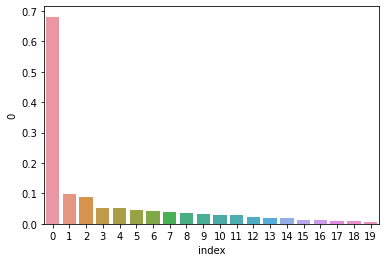

In [65]:
sns.barplot(x=var['index'], y=var[0])

In [84]:
g=seaborn.clustermap(.T, figsize=(25,10), cmap = seaborn.diverging_palette(20,220,n=200), yticklabels=1)


KeyError: (slice(None, 10, None),)

In [26]:
#Run T-SNE on the PCA features.
tsne = TSNE(n_components=2, verbose = 1, perplexity=70)
tsne_results = tsne.fit_transform(full_pc_df.iloc[:, 1:6])

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 892104 samples in 1.107s...
[t-SNE] Computed neighbors for 892104 samples in 161.461s...
[t-SNE] Computed conditional probabilities for sample 1000 / 892104
[t-SNE] Computed conditional probabilities for sample 2000 / 892104
[t-SNE] Computed conditional probabilities for sample 3000 / 892104
[t-SNE] Computed conditional probabilities for sample 4000 / 892104
[t-SNE] Computed conditional probabilities for sample 5000 / 892104
[t-SNE] Computed conditional probabilities for sample 6000 / 892104
[t-SNE] Computed conditional probabilities for sample 7000 / 892104
[t-SNE] Computed conditional probabilities for sample 8000 / 892104
[t-SNE] Computed conditional probabilities for sample 9000 / 892104
[t-SNE] Computed conditional probabilities for sample 10000 / 892104
[t-SNE] Computed conditional probabilities for sample 11000 / 892104
[t-SNE] Computed conditional probabilities for sample 12000 / 892104
[t-SNE] Computed conditional prob

[t-SNE] Computed conditional probabilities for sample 119000 / 892104
[t-SNE] Computed conditional probabilities for sample 120000 / 892104
[t-SNE] Computed conditional probabilities for sample 121000 / 892104
[t-SNE] Computed conditional probabilities for sample 122000 / 892104
[t-SNE] Computed conditional probabilities for sample 123000 / 892104
[t-SNE] Computed conditional probabilities for sample 124000 / 892104
[t-SNE] Computed conditional probabilities for sample 125000 / 892104
[t-SNE] Computed conditional probabilities for sample 126000 / 892104
[t-SNE] Computed conditional probabilities for sample 127000 / 892104
[t-SNE] Computed conditional probabilities for sample 128000 / 892104
[t-SNE] Computed conditional probabilities for sample 129000 / 892104
[t-SNE] Computed conditional probabilities for sample 130000 / 892104
[t-SNE] Computed conditional probabilities for sample 131000 / 892104
[t-SNE] Computed conditional probabilities for sample 132000 / 892104
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 242000 / 892104
[t-SNE] Computed conditional probabilities for sample 243000 / 892104
[t-SNE] Computed conditional probabilities for sample 244000 / 892104
[t-SNE] Computed conditional probabilities for sample 245000 / 892104
[t-SNE] Computed conditional probabilities for sample 246000 / 892104
[t-SNE] Computed conditional probabilities for sample 247000 / 892104
[t-SNE] Computed conditional probabilities for sample 248000 / 892104
[t-SNE] Computed conditional probabilities for sample 249000 / 892104
[t-SNE] Computed conditional probabilities for sample 250000 / 892104
[t-SNE] Computed conditional probabilities for sample 251000 / 892104
[t-SNE] Computed conditional probabilities for sample 252000 / 892104
[t-SNE] Computed conditional probabilities for sample 253000 / 892104
[t-SNE] Computed conditional probabilities for sample 254000 / 892104
[t-SNE] Computed conditional probabilities for sample 255000 / 892104
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 364000 / 892104
[t-SNE] Computed conditional probabilities for sample 365000 / 892104
[t-SNE] Computed conditional probabilities for sample 366000 / 892104
[t-SNE] Computed conditional probabilities for sample 367000 / 892104
[t-SNE] Computed conditional probabilities for sample 368000 / 892104
[t-SNE] Computed conditional probabilities for sample 369000 / 892104
[t-SNE] Computed conditional probabilities for sample 370000 / 892104
[t-SNE] Computed conditional probabilities for sample 371000 / 892104
[t-SNE] Computed conditional probabilities for sample 372000 / 892104
[t-SNE] Computed conditional probabilities for sample 373000 / 892104
[t-SNE] Computed conditional probabilities for sample 374000 / 892104
[t-SNE] Computed conditional probabilities for sample 375000 / 892104
[t-SNE] Computed conditional probabilities for sample 376000 / 892104
[t-SNE] Computed conditional probabilities for sample 377000 / 892104
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 488000 / 892104
[t-SNE] Computed conditional probabilities for sample 489000 / 892104
[t-SNE] Computed conditional probabilities for sample 490000 / 892104
[t-SNE] Computed conditional probabilities for sample 491000 / 892104
[t-SNE] Computed conditional probabilities for sample 492000 / 892104
[t-SNE] Computed conditional probabilities for sample 493000 / 892104
[t-SNE] Computed conditional probabilities for sample 494000 / 892104
[t-SNE] Computed conditional probabilities for sample 495000 / 892104
[t-SNE] Computed conditional probabilities for sample 496000 / 892104
[t-SNE] Computed conditional probabilities for sample 497000 / 892104
[t-SNE] Computed conditional probabilities for sample 498000 / 892104
[t-SNE] Computed conditional probabilities for sample 499000 / 892104
[t-SNE] Computed conditional probabilities for sample 500000 / 892104
[t-SNE] Computed conditional probabilities for sample 501000 / 892104
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 608000 / 892104
[t-SNE] Computed conditional probabilities for sample 609000 / 892104
[t-SNE] Computed conditional probabilities for sample 610000 / 892104
[t-SNE] Computed conditional probabilities for sample 611000 / 892104
[t-SNE] Computed conditional probabilities for sample 612000 / 892104
[t-SNE] Computed conditional probabilities for sample 613000 / 892104
[t-SNE] Computed conditional probabilities for sample 614000 / 892104
[t-SNE] Computed conditional probabilities for sample 615000 / 892104
[t-SNE] Computed conditional probabilities for sample 616000 / 892104
[t-SNE] Computed conditional probabilities for sample 617000 / 892104
[t-SNE] Computed conditional probabilities for sample 618000 / 892104
[t-SNE] Computed conditional probabilities for sample 619000 / 892104
[t-SNE] Computed conditional probabilities for sample 620000 / 892104
[t-SNE] Computed conditional probabilities for sample 621000 / 892104
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 736000 / 892104
[t-SNE] Computed conditional probabilities for sample 737000 / 892104
[t-SNE] Computed conditional probabilities for sample 738000 / 892104
[t-SNE] Computed conditional probabilities for sample 739000 / 892104
[t-SNE] Computed conditional probabilities for sample 740000 / 892104
[t-SNE] Computed conditional probabilities for sample 741000 / 892104
[t-SNE] Computed conditional probabilities for sample 742000 / 892104
[t-SNE] Computed conditional probabilities for sample 743000 / 892104
[t-SNE] Computed conditional probabilities for sample 744000 / 892104
[t-SNE] Computed conditional probabilities for sample 745000 / 892104
[t-SNE] Computed conditional probabilities for sample 746000 / 892104
[t-SNE] Computed conditional probabilities for sample 747000 / 892104
[t-SNE] Computed conditional probabilities for sample 748000 / 892104
[t-SNE] Computed conditional probabilities for sample 749000 / 892104
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 857000 / 892104
[t-SNE] Computed conditional probabilities for sample 858000 / 892104
[t-SNE] Computed conditional probabilities for sample 859000 / 892104
[t-SNE] Computed conditional probabilities for sample 860000 / 892104
[t-SNE] Computed conditional probabilities for sample 861000 / 892104
[t-SNE] Computed conditional probabilities for sample 862000 / 892104
[t-SNE] Computed conditional probabilities for sample 863000 / 892104
[t-SNE] Computed conditional probabilities for sample 864000 / 892104
[t-SNE] Computed conditional probabilities for sample 865000 / 892104
[t-SNE] Computed conditional probabilities for sample 866000 / 892104
[t-SNE] Computed conditional probabilities for sample 867000 / 892104
[t-SNE] Computed conditional probabilities for sample 868000 / 892104
[t-SNE] Computed conditional probabilities for sample 869000 / 892104
[t-SNE] Computed conditional probabilities for sample 870000 / 892104
[t-SNE] Computed con

In [ ]:
pd.DataFrame(tsne_results).to_pickle('tsne_results.pkl')

In [10]:
## get tsne results
tsne_results = pd.read_pickle('tsne_results.pkl').rename(columns={0:'TSNE_1', 1:'TSNE_2'})

In [21]:
tsne_df = pd.concat([tsne_results, df2, df1], axis=1)

In [ ]:
tsne_results, pca_results = pd.read_pickle(r'/hpc/scratch/hdd2/fs541623/Cell_Tox_Assay_080421/FEATURE_EXTRACTION/dimreduction.pkl')

In [20]:
## merge pca df with labels 
pca_df = pd.DataFrame(pca_result[:,0:2]).rename(columns={0:'PC1', 1:'PC2'})
test_df = pd.concat([pca_df,df2, df1 ], axis=1)

In [36]:
tsne_df['TSNE_2']

0        -0.000002
1        -0.000003
2        -0.000004
3        -0.000002
4         0.000004
            ...   
892099   -0.000003
892100   -0.000001
892101   -0.000003
892102    0.000003
892103    0.000001
Name: TSNE_2, Length: 892104, dtype: float32

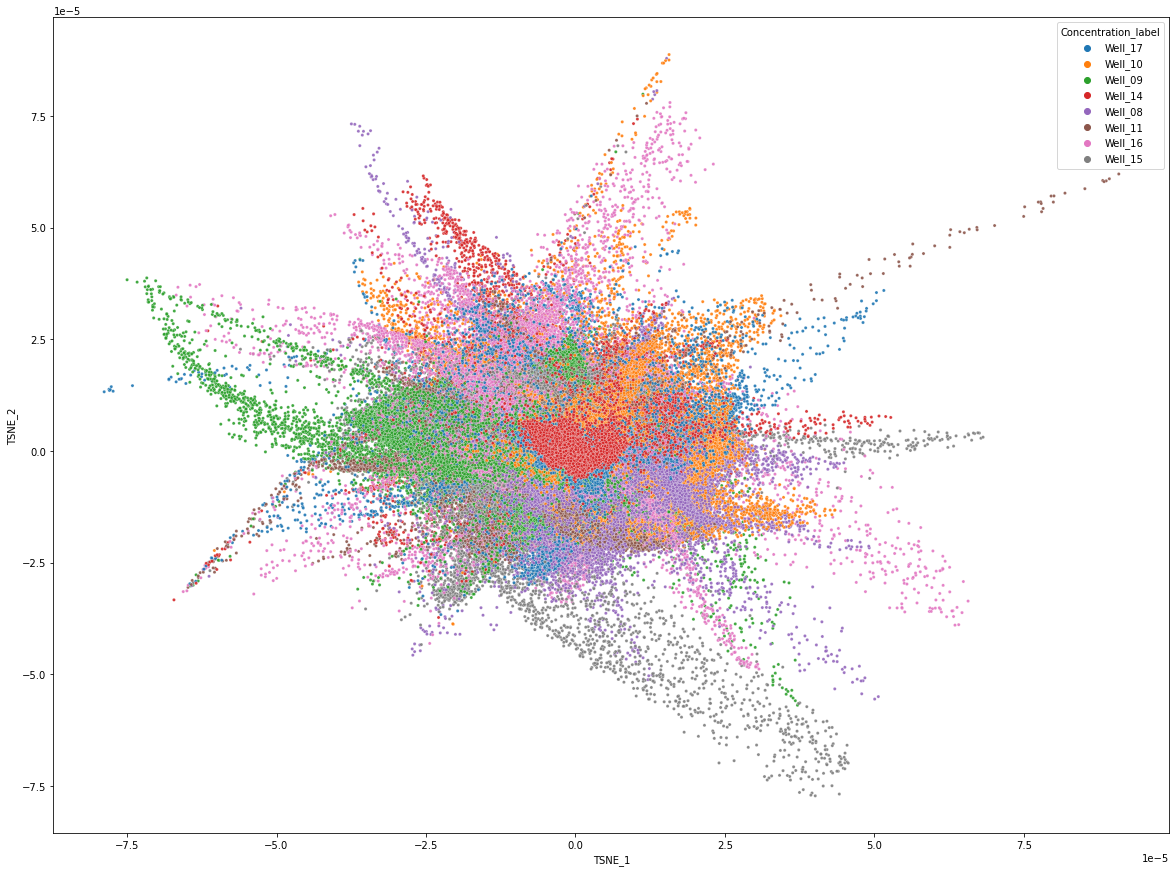

In [38]:
## PCA plot labelled by concentration 
plt.figure(figsize=(20,15))
sns.scatterplot(tsne_df['TSNE_1'], tsne_df['TSNE_2'], hue=tsne_df['Concentration_label'], s=10, alpha=0.9)
plt.savefig('tsne_plot_concentration_label.png')

In [21]:
## join PCA df with predictions and labels
pca_df = pd.concat([pca_df, df1, df2])

/home/fs541623/.conda/envs/fastai/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


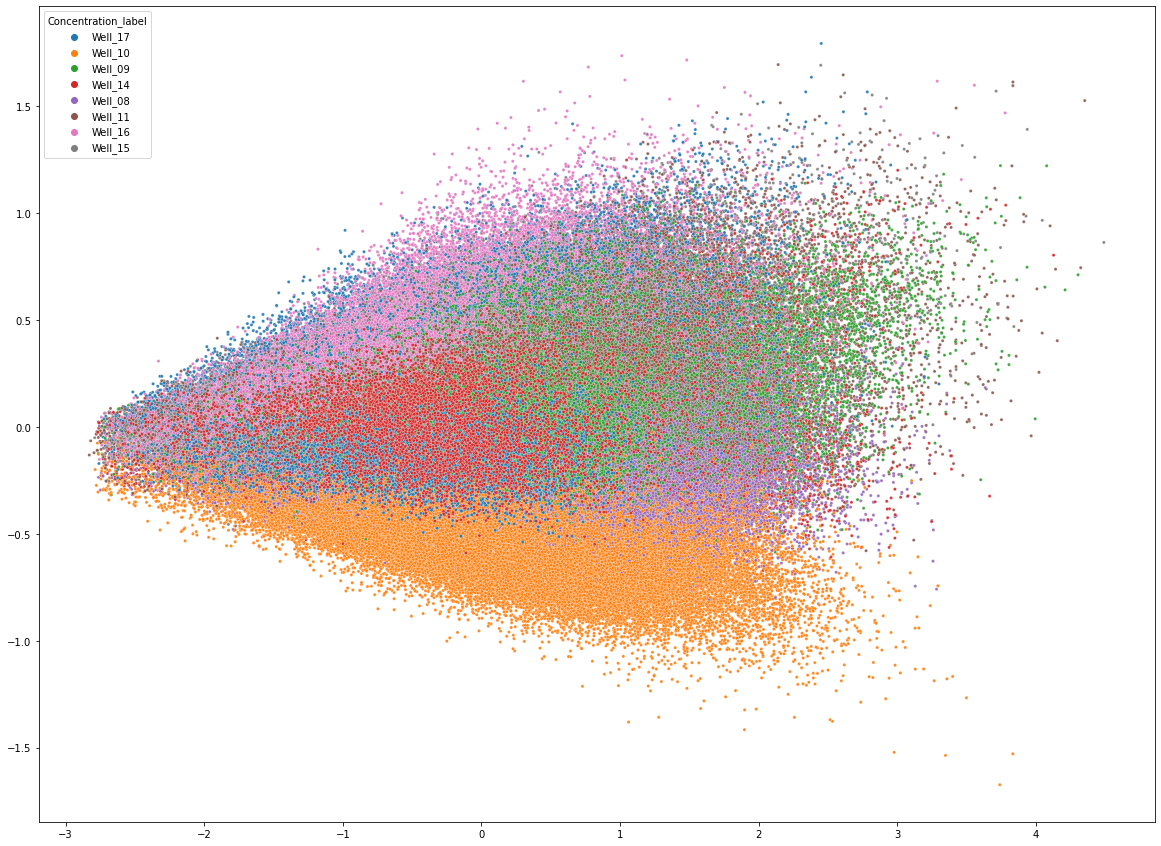

In [101]:
## PCA plot labelled by concentration 
plt.figure(figsize=(20,15))
sns.scatterplot(pca_result[:,0], pca_result[:,1], hue=df2['Concentration_label'], s=10, alpha=0.9)
plt.savefig('pca_plot_concentration_label.png')

/home/fs541623/.conda/envs/fastai/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


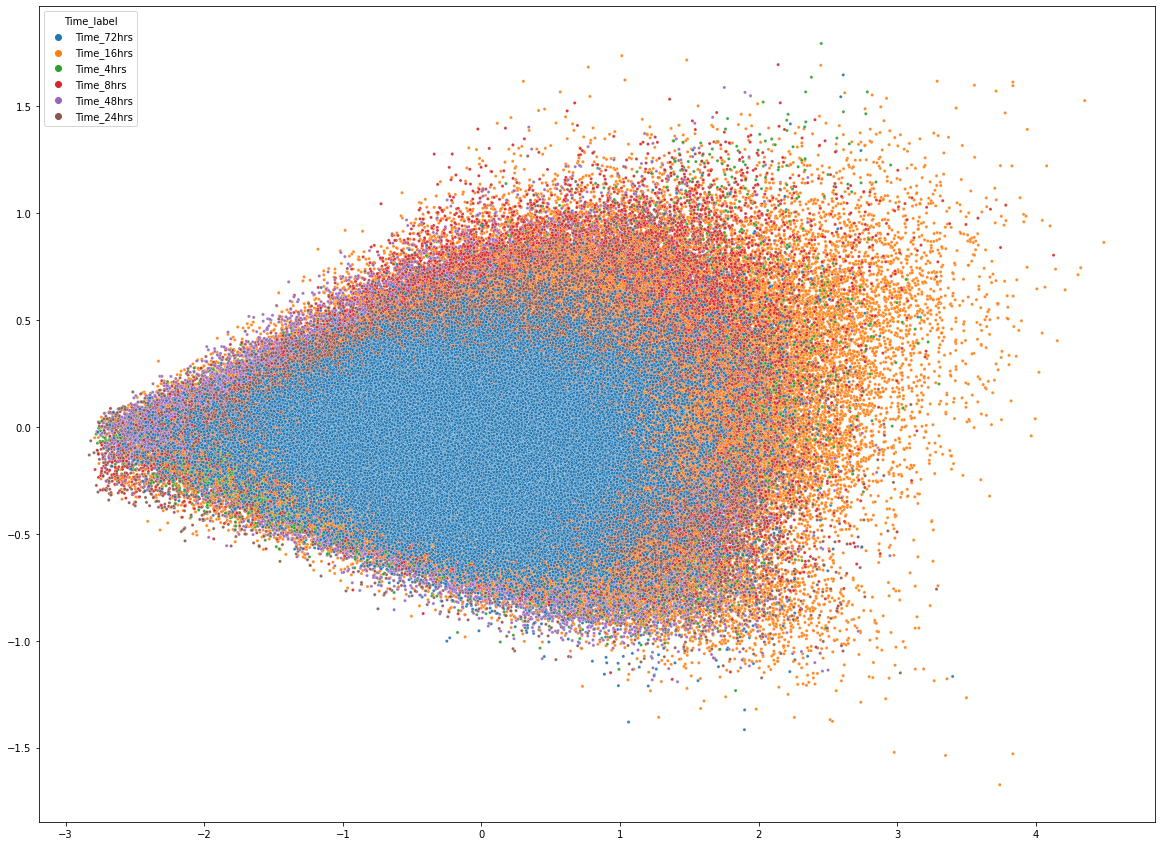

In [102]:
## PCA plot labelled by time 
plt.figure(figsize=(20,15))
sns.scatterplot(pca_result[:,0], pca_result[:,1], hue=df2['Time_label'], s=10, alpha=0.9)
plt.savefig('pca_plot_time_label.png')

<Figure size 1440x1080 with 0 Axes>

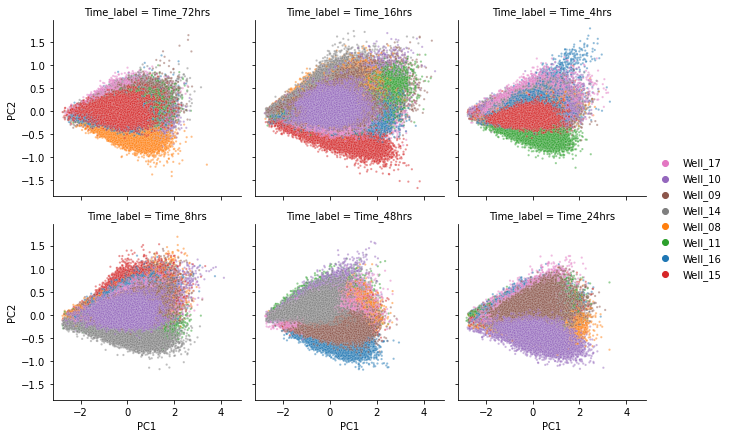

In [191]:
## Show effect of concentration for each timepoint 
plt.figure(figsize=(20,15))
g = sns.FacetGrid(test_df, col='Time_label', col_wrap=3)
g.map_dataframe(sns.scatterplot, x='PC1', y='PC2', hue='Concentration_label', s=3, alpha=0.2)
g.set_axis_labels("PC1", "PC2")
g.add_legend()
plt.savefig('pca_plot_faceted_by_time.png')

<Figure size 1440x1080 with 0 Axes>

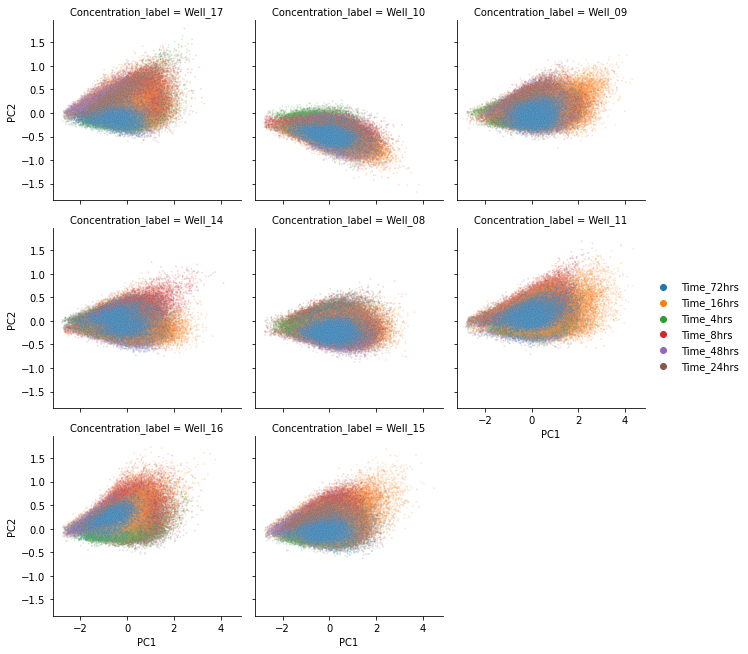

In [23]:
## Show effect of time for each concentration 
plt.figure(figsize=(20,15))
g = sns.FacetGrid(test_df, col='Concentration_label', col_wrap=3)
g.map_dataframe(sns.scatterplot, x='PC1', y='PC2', hue='Time_label', s=3, alpha=0.2)
g.set_axis_labels("PC1", "PC2")
g.add_legend()
plt.savefig('pca_plot_faceted_by_conc.png')

In [144]:
df_test.columns = [' '.join(col).strip() for col in df.columns.values]

X                                                              \
       Feature_1 Feature_2 Feature_3 Feature_4 Feature_5 Feature_6 Feature_7   
0       0.024366  0.009003  0.012650  0.320209  0.066077  0.062036  0.171959   
1       0.033257  0.008423  0.014020  0.351413  0.079335  0.037761  0.187273   
2       0.037881  0.009829  0.011467  0.381027  0.071065  0.053464  0.122864   
3       0.021449  0.006723  0.005065  0.272325  0.077253  0.034653  0.131853   
4       0.013399  0.006228  0.007010  0.228662  0.025404  0.033104  0.065934   
...          ...       ...       ...       ...       ...       ...       ...   
892099  0.011380  0.007440  0.005536  0.307779  0.075378  0.036012  0.067404   
892100  0.012727  0.006703  0.008756  0.323167  0.143373  0.047528  0.031896   
892101  0.033505  0.012825  0.015191  0.488933  0.120023  0.084218  0.043893   
892102  0.037308  0.003131  0.012724  0.170945  0.043061  0.023428  0.099541   
892103  0.022834  0.004026  0.005479  0.196491  0.054830  0.041640  0.027195   

                                       ...                          \
       Feature_8 Feature_9 Feature_10  ... Feature_799 Feature_800   
0       0.020938  0.013072   0.023800  ...    0.028161    0.106817   
1       0.015019  0.027155   0.017719  ...    0.027820    0.141539   
2       0.022481  0.023549   0.022902  ...    0.029388    0.140726   
3       0.013725  0.026232   0.007667  ...    0.039469    0.130659   
4       0.013401  0.019816   0.010021  ...    0.022113    0.073863   
...          ...       ...        ...  ...         ...         ...   
892099  0.009607  0.013993   0.013354  ...    0.028784    0.090366   
892100  0.031865  0.022740   0.011850  ...    0.076967    0.089195   
892101  0.021524  0.030016   0.011217  ...    0.078240    0.211430   
892102  0.008560  0.028005   0.012210  ...    0.027993    0.061840   
892103  0.009563  0.019282   0.007165  ...    0.036314    0.068981   

                  pred                                                      \
       Time_prediction Concentration_prediction        2     3     4     5   
0           Time_72hrs                  Well_17     None  None  None  None   
1           Time_72hrs                  Well_17     None  None  None  None   
2           Time_72hrs                  Well_17     None  None  None  None   
3           Time_72hrs                  Well_17     None  None  None  None   
4           Time_72hrs                  Well_17     None  None  None  None   
...                ...                      ...      ...   ...   ...   ...   
892099      Time_48hrs               Time_72hrs  Well_14  None  None  None   
892100      Time_72hrs                  Well_14     None  None  None  None   
892101         Well_14                     None     None  None  None  None   
892102      Time_72hrs                  Well_14     None  None  None  None   
892103      Time_72hrs                  Well_14     None  None  None  None   

             truth                      
        Time_label Concentration_label  
0       Time_72hrs             Well_17  
1       Time_72hrs             Well_17  
2       Time_72hrs             Well_17  
3       Time_72hrs             Well_17  
4       Time_72hrs             Well_17  
...            ...                 ...  
892099  Time_72hrs             Well_14  
892100  Time_72hrs             Well_14  
892101  Time_72hrs             Well_14  
892102  Time_72hrs             Well_14  
892103  Time_72hrs             Well_14  

[892104 rows x 808 columns]

In [162]:
concat

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_799,Feature_800,Time_prediction,Concentration_prediction,2,3,4,5,Time_label,Concentration_label
0,0.024366,0.009003,0.012650,0.320209,0.066077,0.062036,0.171959,0.020938,0.013072,0.023800,...,0.028161,0.106817,Time_72hrs,Well_17,None,None,None,None,Time_72hrs,Well_17
1,0.033257,0.008423,0.014020,0.351413,0.079335,0.037761,0.187273,0.015019,0.027155,0.017719,...,0.027820,0.141539,Time_72hrs,Well_17,None,None,None,None,Time_72hrs,Well_17
2,0.037881,0.009829,0.011467,0.381027,0.071065,0.053464,0.122864,0.022481,0.023549,0.022902,...,0.029388,0.140726,Time_72hrs,Well_17,None,None,None,None,Time_72hrs,Well_17
3,0.021449,0.006723,0.005065,0.272325,0.077253,0.034653,0.131853,0.013725,0.026232,0.007667,...,0.039469,0.130659,Time_72hrs,Well_17,None,None,None,None,Time_72hrs,Well_17
4,0.013399,0.006228,0.007010,0.228662,0.025404,0.033104,0.065934,0.013401,0.019816,0.010021,...,0.022113,0.073863,Time_72hrs,Well_17,None,None,None,None,Time_72hrs,Well_17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892099,0.011380,0.007440,0.005536,0.307779,0.075378,0.036012,0.067404,0.009607,0.013993,0.013354,...,0.028784,0.090366,Time_48hrs,Time_72hrs,Well_14,None,None,None,Time_72hrs,Well_14
892100,0.012727,0.006703,0.008756,0.323167,0.143373,0.047528,0.031896,0.031865,0.022740,0.011850,...,0.076967,0.089195,Time_72hrs,Well_14,None,None,None,None,Time_72hrs,Well_14
892101,0.033505,0.012825,0.015191,0.488933,0.120023,0.084218,0.043893,0.021524,0.030016,0.011217,...,0.078240,0.211430,Well_14,None,None,None,None,None,Time_72hrs,Well_14
892102,0.037308,0.003131,0.012724,0.170945,0.043061,0.023428,0.099541,0.008560,0.028005,0.012210,...,0.027993,0.061840,Time_72hrs,Well_14,None,None,None,None,Time_72hrs,Well_14


In [30]:
X = pd.read_csv('CP_features.csv')

/home/fs541623/.conda/envs/fastai/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (11,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [38]:
X.head()

,Unnamed: 0,ImageNumber,ObjectNumber,Metadata_Channel,Metadata_Field,Metadata_FileLocation,Metadata_Frame,Metadata_Series,Metadata_Time,Metadata_Well,...,Texture_Variance_Cyt_Crop_3_02_256,Texture_Variance_Cyt_Crop_3_03_256,Texture_Variance_Nuc_Crop_3_00_256,Texture_Variance_Nuc_Crop_3_01_256,Texture_Variance_Nuc_Crop_3_02_256,Texture_Variance_Nuc_Crop_3_03_256,Texture_Variance_PI_Crop_3_00_256,Texture_Variance_PI_Crop_3_01_256,Texture_Variance_PI_Crop_3_02_256,Texture_Variance_PI_Crop_3_03_256
0,0,1,1,NaN,NaN,NaN,0,0,16hrs_R2,16,...,42.153266,40.510908,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,1,2,NaN,NaN,NaN,0,0,16hrs_R2,16,...,153.646438,152.205358,0.006993,0.011493,0.011493,0.012656,0.022817,0.023738,0.023127,0.023584
2,2,1,3,NaN,NaN,NaN,0,0,16hrs_R2,16,...,491.654083,501.208569,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,1,4,NaN,NaN,NaN,0,0,16hrs_R2,16,...,396.940322,379.118385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,1,5,NaN,NaN,NaN,0,0,16hrs_R2,16,...,1146.991216,1103.598998,0.103056,0.111818,0.106520,0.098765,0.000000,0.000000,0.000000,0.000000


In [ ]:
fg = sbn.FacetGrid(result, row='b', col='a')
fg.map(plt.scatter, "x", "y", color='blue')

In [138]:
pca_df[4]

0         0.032522
1        -0.000277
2         0.028622
3         0.117589
4         0.019657
            ...   
892099         NaN
892100         NaN
892101         NaN
892102         NaN
892103         NaN
Name: 4, Length: 2676312, dtype: object

In [90]:
## Filter on contr
concat['truth']['Concentration_label'] == 'Well_08'

0         Well_17
1         Well_17
2         Well_17
3         Well_17
4         Well_17
           ...   
892099    Well_14
892100    Well_14
892101    Well_14
892102    Well_14
892103    Well_14
Name: Concentration_label, Length: 892104, dtype: object

In [42]:
XX['Metadata_Well'] == '8'

,Unnamed: 0,ImageNumber,ObjectNumber,Metadata_Channel,Metadata_Field,Metadata_FileLocation,Metadata_Frame,Metadata_Series,Metadata_Time,Metadata_Well,...,Texture_Variance_Cyt_Crop_3_02_256,Texture_Variance_Cyt_Crop_3_03_256,Texture_Variance_Nuc_Crop_3_00_256,Texture_Variance_Nuc_Crop_3_01_256,Texture_Variance_Nuc_Crop_3_02_256,Texture_Variance_Nuc_Crop_3_03_256,Texture_Variance_PI_Crop_3_00_256,Texture_Variance_PI_Crop_3_01_256,Texture_Variance_PI_Crop_3_02_256,Texture_Variance_PI_Crop_3_03_256


In [86]:
(concat['Concentration_label'] == 'Well_08')

KeyError: 'Concentration_label'

In [39]:
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data ### can calculate mean.sd from control
norm = MinMaxScaler().fit(X)

# transform training data using normalization to training data 
X_train_norm = norm.transform(X)

ValueError: could not convert string to float: '16hrs_R2'

In [ ]:
data = [[y],[z]]

In [ ]:
numpy_data = np.array([y.flatten(), z.flatten()])

In [ ]:
numpy_data.shape

In [ ]:
df = pd.DataFrame()

In [ ]:
df['col1'] = y.flatten()
df['col2'] = z.flatten()

In [ ]:
impor

In [ ]:
pd.DataFrame(data=numpy_data[None,:,:], index=['row1','row2'])

In [ ]:
tsne_results[:,0]

In [ ]:
images, labels, preds = get_predictions(model, x, y)

In [ ]:
pred_l = L([i for i in preds])
labels_l = L([i for i in labels])

In [ ]:
pred_l.map(label_decoder)

In [ ]:
labels_l.map(label_decoder)

In [ ]:
# confusion matrix 
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (50, 50));
    ax = fig.add_subplot(1, 1, 1);
    cm = multilabel_confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 50)
    plt.ylabel('True Label', fontsize = 50)

In [ ]:
plot_confusion_matrix(labels, preds, classes)

In [ ]:
pd.read.pickle()